In [ ]:
pip install pydicom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 37.6 MB/s eta 0:00:00


In [ ]:
from pathlib import Path

import pydicom
import matplotlib.pyplot as plt
import numpy as np

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 33.0 MB/s eta 0:00:00


### Download SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os
HOME="/content/{HOME}"
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/{HOME}/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
sample_dcm = "/content/I0000002.dcm"
dicom_file = pydicom.dcmread(sample_dcm)

In [ ]:
dicom_file.pixel_array[122].shape

(600, 600)

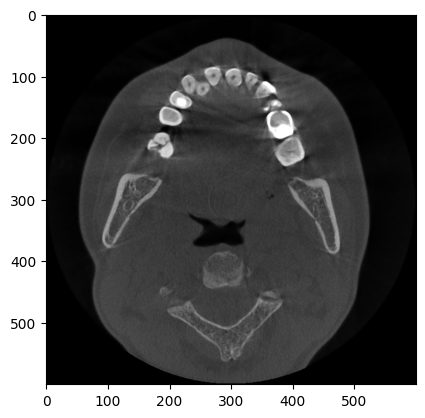

In [ ]:
ct = dicom_file.pixel_array[122] # load the image pixel data as a numpy array
plt.figure()
plt.imshow(ct, cmap="gray")

In [ ]:
import cv2
import supervision as sv
print(ct.shape)
image_rgb = cv2.cvtColor(ct, cv2.COLOR_GRAY2RGB) ##dicom
# image_rgb = cv2.cvtColor(image_array[:,:,13].astype('uint8'), cv2.COLOR_GRAY2RGB) #nifti
print(image_rgb.shape)

(600, 600)
(600, 600, 3)


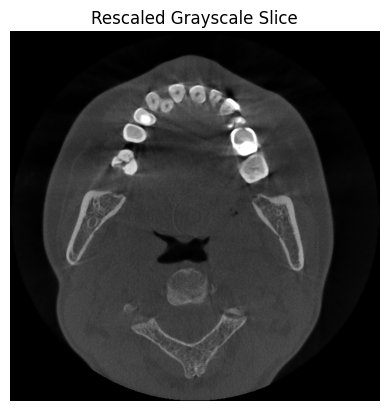

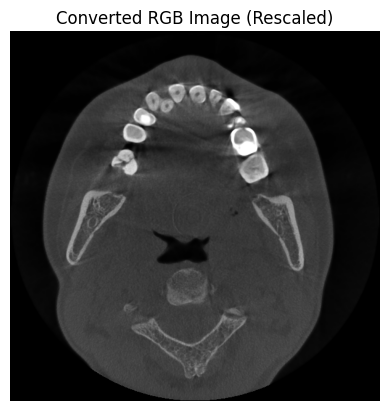

In [ ]:
slice_image = ct
slice_rescaled = ((slice_image - np.min(slice_image)) / (np.max(slice_image) - np.min(slice_image)) * 255).astype(np.uint8)

# Convert grayscale to RGB
image_rgb = cv2.cvtColor(slice_rescaled, cv2.COLOR_GRAY2RGB)
plt.imshow(slice_rescaled, cmap="gray")
plt.axis("off")
plt.title("Rescaled Grayscale Slice")
plt.show()

plt.imshow(image_rgb)
plt.axis("off")
plt.title("Converted RGB Image (Rescaled)")
plt.show()

### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
import io
from PIL import Image
import base64
import numpy as np
from jupyter_bbox_widget import BBoxWidget

def convert_to_uint8(image_array):
    if image_array.dtype == np.uint16:
        image_array = ((image_array / image_array.max()) * 255).astype(np.uint8)
    return image_array

def encode_image_from_array(image_array):
    image_array = convert_to_uint8(image_array)

    image_pil = Image.fromarray(image_array)
    buffer = io.BytesIO()
    image_pil.save(buffer, format="PNG")
    encoded = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return "data:image/png;base64," + encoded

encoded_image = encode_image_from_array(image_rgb)

widget = BBoxWidget()
widget.image = encoded_image
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes[0]['label']='right_mandible'
widget.bboxes[1]['label']='left_mandible'

In [ ]:
widget.bboxes

[{'x': 387, 'y': 260, 'width': 119, 'height': 142, 'label': 'right_mandible'},
 {'x': 81, 'y': 259, 'width': 111, 'height': 120, 'label': 'left_mandible'}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [ ]:
len(widget.bboxes)

2

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
boxes = widget.bboxes
# box = np.array([
#     box['x'],
#     box['y'],
#     box['x'] + box['width'],
#     box['y'] + box['height']
# ])
box_array = []

for box in boxes:
    box_coords = [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ]
    box_array.append(box_coords)

# Convert the list to a NumPy array
box_array = np.array(box_array)

print("All bounding boxes:", box_array)

All bounding boxes: [[387 260 506 402]
 [ 81 259 192 379]]


In [ ]:
import cv2
import numpy as np
import supervision as sv

mask_predictor.set_image(convert_to_uint8(image_rgb))

all_masks, all_scores, all_logits = [], [], []

# Loop through each bounding box for prediction
for box in box_array:
    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )

    # Append the results for this box
    all_masks.append(masks)
    all_scores.append(scores)
    all_logits.append(logits)

# Convert lists to NumPy arrays if needed
all_masks = np.concatenate(all_masks) if all_masks else None
all_scores = np.concatenate(all_scores) if all_scores else None
all_logits = np.concatenate(all_logits) if all_logits else None


In [ ]:
image_rgb=convert_to_uint8(image_rgb)

### Results visualisation with Supervision

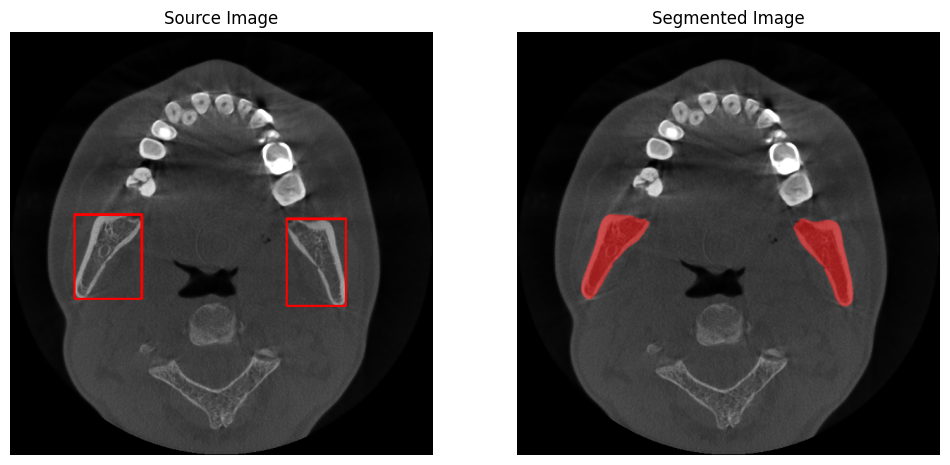

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=all_masks),  # Use all detected masks here
    mask=all_masks
)
source_image = box_annotator.annotate(scene=image_rgb.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['Source Image', 'Segmented Image']
)

### Interaction with segmentation results

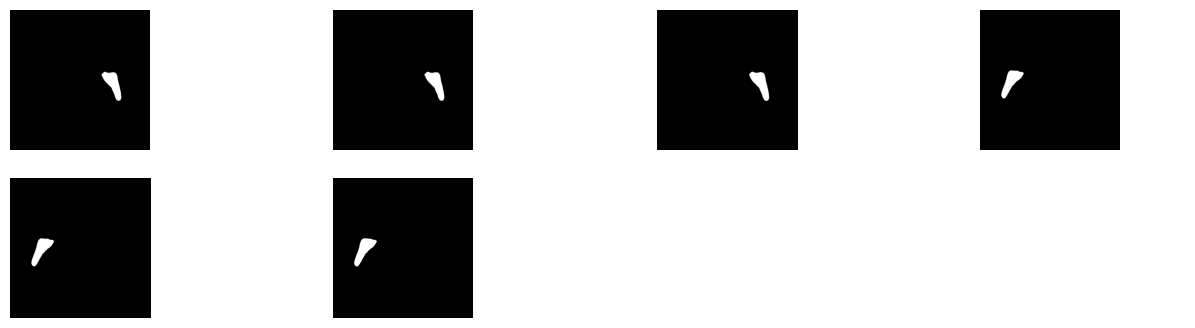

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=all_masks,
    grid_size=(2, 4),
    size=(16, 4)
)